## Классификация постов
Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


tf-nightly нужен, т.к. f.keras.metrics.F1Score работает только для tf-nightly. См. https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

In [2]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.2/488.2 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 50.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [4]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина поста
max_len = 11
# Количество классов
nb_classes = 15

## Загрузка набора данных

In [5]:
df_em_1_token_10 = pd.read_csv('df_em_1_token_10.csv', sep=";")

In [6]:
df_em_1_token_10

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
0,😂,5,1,smile,positive/negative,0,почему бы и нет 😂
1,😁,5,1,smile,positive/negative,0,как сесть на диету 😁
2,😁,6,1,smile,positive/negative,0,когда в душе ещё щенок 😁
3,😻,6,1,joy,positive,2,новые фотографии нюши просто огненные😻
4,😍,7,1,joy,positive,2,безумно красивая актриса - алина ланина 😍
...,...,...,...,...,...,...,...
9215,😄,5,1,smile,positive/negative,0,ряды эскортниц скоро пополнится 😄
9216,😂,7,1,smile,positive/negative,0,так он прав ты реально даун 😂
9217,🤔,7,1,no_emotion,neutral/skeptical,1,вы же не про меня?🤔
9218,🤔,9,1,no_emotion,neutral/skeptical,1,про кого пошутил то это не до комик🤔


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(df_em_1_token_10, test_size=0.2)

In [9]:
train

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
416,😅,7,1,smile,positive/negative,0,когда ну все просто против тебя😅
8101,😃,5,1,smile,positive/negative,0,мозгов то осталось немного😃
4600,🤭,4,1,no_emotion,neutral/skeptical,1,телеграм этим славится 🤭
5931,🤣,2,1,smile,positive/negative,0,хз 🤣
7539,😱,6,1,fear,negative,5,норм с мишей там.....😱
...,...,...,...,...,...,...,...
5555,😁,11,1,smile,positive/negative,0,якудза тебя найдёт и заставит сделать харакири...
8231,😅,7,1,smile,positive/negative,0,тут уже конечно кто как привык😅
6788,😂,8,1,smile,positive/negative,0,чего ?😂 я don't понимать ваш язык
7361,😀,3,1,smile,positive/negative,0,отличный сериал😀


In [10]:
test

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
8112,😅,5,1,smile,positive/negative,0,или стёкл как трезвышко😅
7290,😆,4,1,smile,positive/negative,0,одни в кровати😆
5976,😁,4,1,smile,positive/negative,0,такой же вопрос 😁
169,😅,9,1,smile,positive/negative,0,для мужчин это очень большое признание в чувст...
3266,😹,6,1,smile,positive/negative,0,ой ну я же серьезно 😹
...,...,...,...,...,...,...,...
2683,😍,9,1,joy,positive,2,где шмотки купить как на первой фотке ? 😍
2543,🤣,8,1,smile,positive/negative,0,"и наш петров ,всегда один и тот-же 🤣"
6063,😡,3,1,anger,negative,7,питушинная башка 😡
8144,😊,9,1,smile,positive/negative,0,спасибо большое! и вам всего чего желаете😊


Выделяем данные для обучения

In [11]:
posts_train = train['clean_text']
posts_test = test['clean_text']

In [12]:
posts_train[:5]

416     когда ну все просто против тебя😅
8101         мозгов то осталось немного😃
4600            телеграм этим славится 🤭
5931                                хз 🤣
7539             норм  с мишей там.....😱
Name: clean_text, dtype: object

In [13]:
posts_test[:5]

8112                             или стёкл как трезвышко😅
7290                                      одни в кровати😆
5976                                    такой же вопрос 😁
169     для мужчин это очень большое признание в чувст...
3266                                ой ну я же серьезно 😹
Name: clean_text, dtype: object

Выделяем правильные ответы

In [14]:
y_train = utils.to_categorical(train['class'], nb_classes)

In [15]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [17]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Токенизация текста

Создаем токенизатор Keras

In [18]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на постах

In [19]:
tokenizer.fit_on_texts(posts_train)

Просматриваем словарь токенизатора

In [20]:
tokenizer.word_index

{'не': 1,
 'и': 2,
 'в': 3,
 '🤣': 4,
 'а': 5,
 'это': 6,
 'что': 7,
 'я': 8,
 'на': 9,
 '😂': 10,
 '😁': 11,
 'у': 12,
 'так': 13,
 'с': 14,
 'как': 15,
 '😅': 16,
 'то': 17,
 'ты': 18,
 'ну': 19,
 '😄': 20,
 'да': 21,
 '🤔': 22,
 'за': 23,
 'вот': 24,
 'же': 25,
 'вы': 26,
 'все': 27,
 'по': 28,
 'тоже': 29,
 '😉': 30,
 'уже': 31,
 '😊': 32,
 '😆': 33,
 '😏': 34,
 'он': 35,
 'просто': 36,
 'бы': 37,
 'мне': 38,
 'когда': 39,
 'меня': 40,
 'только': 41,
 'если': 42,
 'для': 43,
 'есть': 44,
 'ещё': 45,
 '😃': 46,
 '😍': 47,
 'из': 48,
 'спасибо': 49,
 'там': 50,
 'она': 51,
 'нет': 52,
 'но': 53,
 'они': 54,
 'от': 55,
 'кто': 56,
 'к': 57,
 '😎': 58,
 'очень': 59,
 'всё': 60,
 '😳': 61,
 'было': 62,
 'можно': 63,
 'надо': 64,
 'будет': 65,
 'тебя': 66,
 '❤': 67,
 'без': 68,
 'вообще': 69,
 'или': 70,
 'даже': 71,
 'до': 72,
 'тебе': 73,
 'тогда': 74,
 'может': 75,
 'его': 76,
 'этот': 77,
 'зачем': 78,
 'вас': 79,
 'какой': 80,
 'где': 81,
 'лучше': 82,
 'вам': 83,
 'тут': 84,
 'чем': 85,
 'о': 86

Преобразуем посты в числовое представление

In [21]:
sequences_train = tokenizer.texts_to_sequences(posts_train)

In [22]:
index = 100
print(posts_train[index])
print(sequences_train[index])

❤, если здесь не хватает коли
[918, 9, 6, 101, 59, 3197, 733, 16]


In [23]:
tokenizer.word_index['здесь']

196

In [24]:
sequences_test = tokenizer.texts_to_sequences(posts_test)

Ограничиваем длину постов

In [26]:
x_train = pad_sequences(sequences_train, maxlen=max_len)

In [27]:
x_test = pad_sequences(sequences_test, maxlen=max_len)

In [28]:
x_train[:5]

array([[   0,    0,    0,    0,    0,   39,   19,   27,   36,  475, 1669],
       [   0,    0,    0,    0,    0,    0,    0, 1670,   17, 1155, 3060],
       [   0,    0,    0,    0,    0,    0,    0, 1671,  260, 3061,  400],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1672,    4],
       [   0,    0,    0,    0,    0,    0,  328,   14, 3062,   50,  165]],
      dtype=int32)

In [29]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,   70,   15],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  985,    3],
       [   0,    0,    0,    0,    0,    0,    0,   90,   25,  295,   11],
       [   0,    0,    0,    0,   43,  941,    6,   59,  549, 4468,    3],
       [   0,    0,    0,    0,    0,  358,   19,    8,   25, 2288,  262]],
      dtype=int32)

In [30]:
#def recall_m(y_true, y_pred):
 #   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
   # recall = true_positives / (possible_positives + K.epsilon())
    #return recall

In [31]:
#def precision_m(y_true, y_pred):
 #   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
   # precision = true_positives / (predicted_positives + K.epsilon())
   # return precision

In [32]:
#def f1_m(y_true, y_pred):
 #   precision = precision_m(y_true, y_pred)
  #  recall = recall_m(y_true, y_pred)
   # return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Сверточная нейронная сеть

In [33]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(15, activation='softmax'))

In [34]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [35]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 7, 250)            40250     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 394313 (1.50 MB)
Trainable params: 394313 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [36]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      #monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [37]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=15,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 1.7460 - accuracy: 0.6265 - precision: 0.6419 - recall: 0.3578 - f1_score_macro: 0.0543 - f1_score_micro: 0.6265 - f1_score_weighted: 0.4965
Epoch 1: val_loss improved from inf to 1.34511, saving model to best_model_cnn.h5
52/52 [==============================] - 17s 113ms/step - loss: 1.7460 - accuracy: 0.6265 - precision: 0.6419 - recall: 0.3578 - f1_score_macro: 0.0543 - f1_score_micro: 0.6265 - f1_score_weighted: 0.4965 - val_loss: 1.3451 - val_accuracy: 0.6477 - val_precision: 0.6471 - val_recall: 0.6436 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 2/15
 1/52 [..............................] - ETA: 0s - loss: 1.2474 - accuracy: 0.7188 - precision: 0.7339 - recall: 0.7109 - f1_score_macro: 0.0558 - f1_score_micro: 0.7188 - f1_score_weighted: 0.6011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.2411 - accuracy: 0.6395 - precision: 0.6945 - recall: 0.5994 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989
Epoch 2: val_loss improved from 1.34511 to 1.10770, saving model to best_model_cnn.h5
52/52 [==============================] - 6s 109ms/step - loss: 1.2411 - accuracy: 0.6395 - precision: 0.6945 - recall: 0.5994 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989 - val_loss: 1.1077 - val_accuracy: 0.6545 - val_precision: 0.8730 - val_recall: 0.4472 - val_f1_score_macro: 0.0618 - val_f1_score_micro: 0.6545 - val_f1_score_weighted: 0.5239
Epoch 3/15
52/52 [==============================] - ETA: 0s - loss: 0.8862 - accuracy: 0.7186 - precision: 0.9421 - recall: 0.6422 - f1_score_macro: 0.1181 - f1_score_micro: 0.7186 - f1_score_weighted: 0.6329
Epoch 3: val_loss improved from 1.10770 to 0.91541, saving model to best_model_cnn.h5
52/52 [==============================] -

смотрим на f1_weighted, т.к. датасет несбалансирован

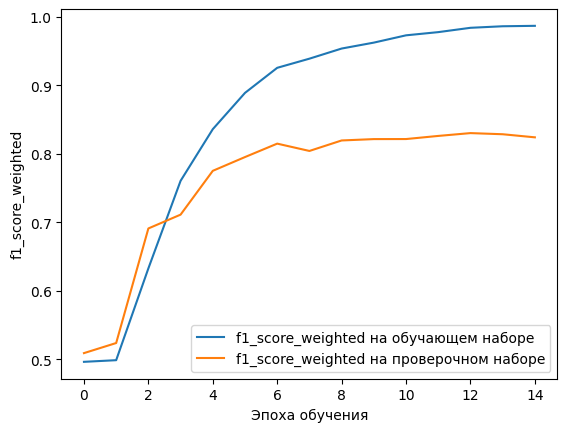

In [38]:
plt.plot(history_cnn.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_cnn.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

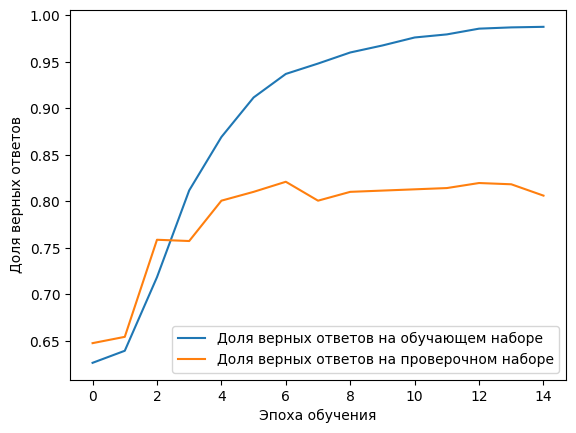

In [39]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [40]:
cnn_loaded = load_model("best_model_cnn.h5")

In [41]:
cnn_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 0.8271 - accuracy: 0.8151 - precision: 0.9044 - recall: 0.6925 - f1_score_macro: 0.2777 - f1_score_micro: 0.8151 - f1_score_weighted: 0.7896


[0.8271034359931946,
 0.8150759339332581,
 0.9043909311294556,
 0.6925162672996521,
 0.27771100401878357,
 0.8150759339332581,
 0.7895717024803162]

In [42]:
predicted_cnn = cnn_loaded.predict(x_test)

58/58 [==============================] - 0s 2ms/step


In [43]:
import sklearn.metrics as sklearn_metrics
import numpy as np

In [44]:
report_cnn = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_cnn, axis=1))
print(report_cnn)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1231
           1       0.75      0.69      0.72       190
           2       0.67      0.77      0.72       146
           3       0.62      0.62      0.62        90
           4       0.93      0.59      0.72        70
           5       0.00      0.00      0.00        18
           6       0.88      0.35      0.50        20
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3

    accuracy                           0.82      1844
   macro avg       0.31      0.26      0.28      1844
weighted avg       0.77   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
with open("CNN_15.txt", 'w') as w_file:
  w_file.write(report_cnn)

## Cеть LSTM

In [46]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(15, activation='softmax'))

In [47]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
             metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [48]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 15)                255       
                                                                 
Total params: 323391 (1.23 MB)
Trainable params: 323391 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [49]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      #monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [50]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=15,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 2.4049 - accuracy: 0.5943 - precision_1: 1.0000 - recall_1: 4.5194e-04 - f1_score_macro: 0.0594 - f1_score_micro: 0.5943 - f1_score_weighted: 0.4873    
Epoch 1: val_loss improved from inf to 1.60572, saving model to best_model_lstm.h5
52/52 [==============================] - 9s 97ms/step - loss: 2.4049 - accuracy: 0.5943 - precision_1: 1.0000 - recall_1: 4.5194e-04 - f1_score_macro: 0.0594 - f1_score_micro: 0.5943 - f1_score_weighted: 0.4873 - val_loss: 1.6057 - val_accuracy: 0.6477 - val_precision_1: 0.8123 - val_recall_1: 0.3753 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 2/15
 2/52 [>.............................] - ETA: 5s - loss: 1.6168 - accuracy: 0.6445 - precision_1: 0.8077 - recall_1: 0.3281 - f1_score_macro: 0.0523 - f1_score_micro: 0.6445 - f1_score_weighted: 0.5052

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.4669 - accuracy: 0.6395 - precision_1: 0.6477 - recall_1: 0.6211 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989
Epoch 2: val_loss improved from 1.60572 to 1.33350, saving model to best_model_lstm.h5
52/52 [==============================] - 2s 46ms/step - loss: 1.4669 - accuracy: 0.6395 - precision_1: 0.6477 - recall_1: 0.6211 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989 - val_loss: 1.3335 - val_accuracy: 0.6477 - val_precision_1: 0.6477 - val_recall_1: 0.6477 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 3/15
52/52 [==============================] - ETA: 0s - loss: 1.2698 - accuracy: 0.6395 - precision_1: 0.7133 - recall_1: 0.6395 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989
Epoch 3: val_loss improved from 1.33350 to 1.19967, saving model to best_model_lstm.h5
52/52 [================

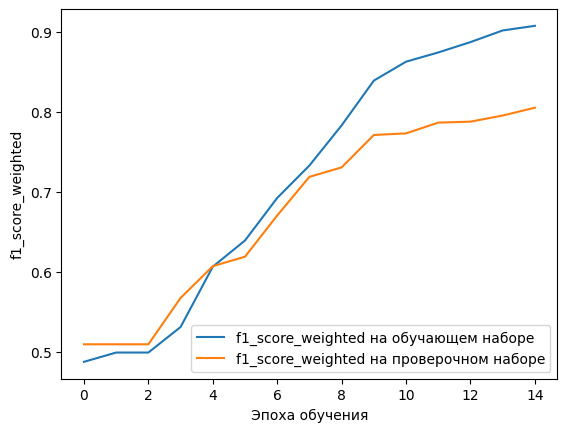

In [51]:
plt.plot(history_lstm.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_lstm.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

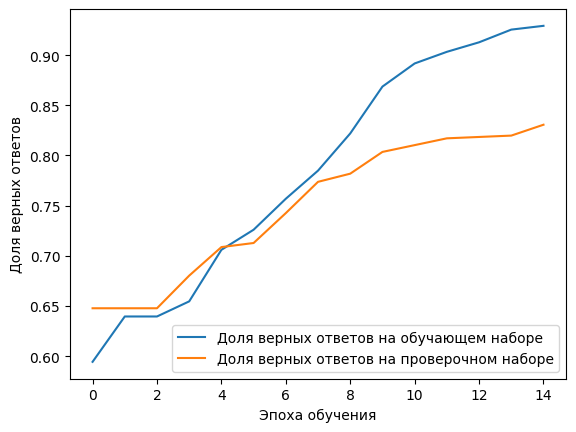

In [52]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [53]:
lstm_loaded = load_model("best_model_lstm.h5")

In [54]:
lstm_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 0.7405 - accuracy: 0.8227 - precision_1: 0.8795 - recall_1: 0.7880 - f1_score_macro: 0.2934 - f1_score_micro: 0.8227 - f1_score_weighted: 0.7981


[0.7404665350914001,
 0.8226681351661682,
 0.879539966583252,
 0.787960946559906,
 0.2934078276157379,
 0.8226681351661682,
 0.7980895638465881]

In [55]:
predicted_lstm = lstm_loaded.predict(x_test)

58/58 [==============================] - 1s 3ms/step


In [56]:
report_lstm = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_lstm, axis=1))
print(report_lstm)

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1231
           1       0.61      0.69      0.65       190
           2       0.86      0.66      0.75       146
           3       0.78      0.62      0.69        90
           4       0.91      0.60      0.72        70
           5       1.00      0.06      0.11        18
           6       0.52      0.65      0.58        20
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3

    accuracy                           0.82      1844
   macro avg       0.37      0.28      0.29      1844
weighted avg       0.79   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
with open("LSTM_15.txt", 'w') as w_file:
  w_file.write(report_lstm)

## Cеть GRU

In [58]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_len))
model_gru.add(GRU(16))
model_gru.add(Dense(15, activation='softmax'))

In [59]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
               metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [60]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 11, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 15)                255       
                                                                 
Total params: 322655 (1.23 MB)
Trainable params: 322655 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model_gru.h5

In [61]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      #monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [62]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=15,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 2.3564 - accuracy: 0.5916 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score_macro: 0.0663 - f1_score_micro: 0.5916 - f1_score_weighted: 0.4935
Epoch 1: val_loss improved from inf to 1.58359, saving model to best_model_gru.h5
52/52 [==============================] - 8s 109ms/step - loss: 2.3564 - accuracy: 0.5916 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score_macro: 0.0663 - f1_score_micro: 0.5916 - f1_score_weighted: 0.4935 - val_loss: 1.5836 - val_accuracy: 0.6477 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.3268 - accuracy: 0.6395 - precision_2: 0.7005 - recall_2: 0.5810 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989
Epoch 2: val_loss improved from 1.58359 to 1.19182, saving model to best_model_gru.h5
52/52 [==============================] - 3s 57ms/step - loss: 1.3268 - accuracy: 0.6395 - precision_2: 0.7005 - recall_2: 0.5810 - f1_score_macro: 0.0520 - f1_score_micro: 0.6395 - f1_score_weighted: 0.4989 - val_loss: 1.1918 - val_accuracy: 0.6477 - val_precision_2: 0.7469 - val_recall_2: 0.6477 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 3/15
52/52 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6885 - precision_2: 0.8397 - recall_2: 0.6390 - f1_score_macro: 0.1094 - f1_score_micro: 0.6885 - f1_score_weighted: 0.5927
Epoch 3: val_loss improved from 1.19182 to 0.99827, saving model to best_model_gru.h5
52/52 [==================

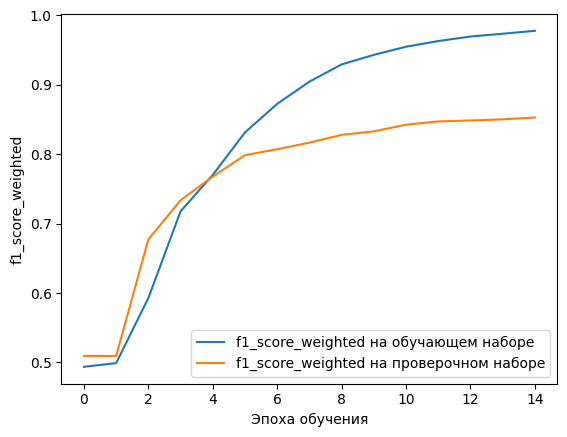

In [63]:
plt.plot(history_gru.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_gru.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

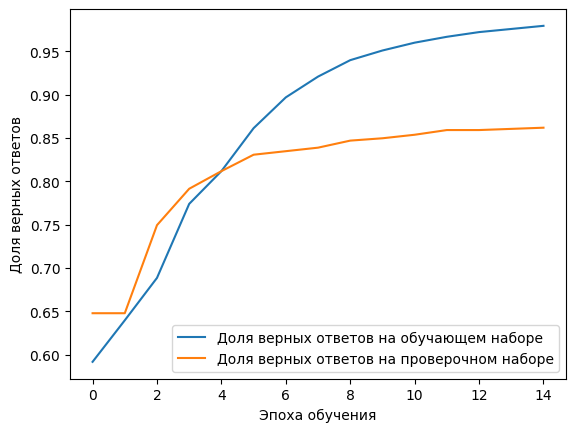

In [64]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [65]:
gru_loaded = load_model("best_model_gru.h5")

In [66]:
gru_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 0.6599 - accuracy: 0.8514 - precision_2: 0.8855 - recall_2: 0.8091 - f1_score_macro: 0.4877 - f1_score_micro: 0.8514 - f1_score_weighted: 0.8374


[0.6598932147026062,
 0.8514099717140198,
 0.8854599595069885,
 0.8091106414794922,
 0.48772791028022766,
 0.8514099717140198,
 0.8373979926109314]

In [67]:
predicted_gru = gru_loaded.predict(x_test)

58/58 [==============================] - 0s 2ms/step


In [68]:
report_gru = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_gru, axis=1))
print(report_gru)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1231
           1       0.81      0.67      0.73       190
           2       0.79      0.66      0.72       146
           3       0.74      0.63      0.68        90
           4       0.92      0.70      0.80        70
           5       1.00      0.61      0.76        18
           6       0.93      0.65      0.76        20
           7       1.00      0.29      0.44        21
           8       1.00      0.20      0.33        10
           9       0.80      0.42      0.55        19
          10       1.00      0.44      0.62         9
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3

    accuracy                           0.85      1844
   macro avg       0.66      0.42      0.49      1844
weighted avg       0.84   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
with open("GRU_15.txt", 'w') as w_file:
  w_file.write(report_gru)

## Загружаем набор данных для тестирования


In [70]:
test

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
8112,😅,5,1,smile,positive/negative,0,или стёкл как трезвышко😅
7290,😆,4,1,smile,positive/negative,0,одни в кровати😆
5976,😁,4,1,smile,positive/negative,0,такой же вопрос 😁
169,😅,9,1,smile,positive/negative,0,для мужчин это очень большое признание в чувст...
3266,😹,6,1,smile,positive/negative,0,ой ну я же серьезно 😹
...,...,...,...,...,...,...,...
2683,😍,9,1,joy,positive,2,где шмотки купить как на первой фотке ? 😍
2543,🤣,8,1,smile,positive/negative,0,"и наш петров ,всегда один и тот-же 🤣"
6063,😡,3,1,anger,negative,7,питушинная башка 😡
8144,😊,9,1,smile,positive/negative,0,спасибо большое! и вам всего чего желаете😊


Преобразуем посты в числовое представление

Нужно использовать токенизатор, обученный на наборе данных train.

In [71]:
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

In [72]:
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [73]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,   70,   15],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  985,    3],
       [   0,    0,    0,    0,    0,    0,    0,   90,   25,  295,   11],
       [   0,    0,    0,    0,   43,  941,    6,   59,  549, 4468,    3],
       [   0,    0,    0,    0,    0,  358,   19,    8,   25, 2288,  262]],
      dtype=int32)

Правильные ответы

In [74]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [75]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Оцениваем качество работы сети на тестовом наборе данных


### Одномерная сверточная сеть

In [76]:
model_cnn.load_weights(model_cnn_save_path)

In [77]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_cnn.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 7ms/step - loss: 0.8271 - accuracy: 0.8151 - precision: 0.9044 - recall: 0.6925 - f1_score_macro: 0.2777 - f1_score_micro: 0.8151 - f1_score_weighted: 0.7896


### Сеть LSTM

In [78]:
model_lstm.load_weights(model_lstm_save_path)

In [79]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_lstm.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 11ms/step - loss: 0.7405 - accuracy: 0.8227 - precision_1: 0.8795 - recall_1: 0.7880 - f1_score_macro: 0.2934 - f1_score_micro: 0.8227 - f1_score_weighted: 0.7981


### Сеть GRU

In [80]:
model_gru.load_weights(model_gru_save_path)

In [81]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_gru.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 4ms/step - loss: 0.6599 - accuracy: 0.8514 - precision_2: 0.8855 - recall_2: 0.8091 - f1_score_macro: 0.4877 - f1_score_micro: 0.8514 - f1_score_weighted: 0.8374


In [93]:
#test['clean_text'][592]
test['clean_text'][500]

'повезло 😅'

In [94]:
#test['class'][2384], test['emotion'][2384], test['tonality'][2384]
test['class'][500], test['emotion'][500], test['tonality'][500]

(0, 'smile', 'positive/negative')

In [95]:
#text = test['clean_text'][2384]
text = test['clean_text'][500]

In [96]:
sequence = tokenizer.texts_to_sequences([text])

In [97]:
sequence

[[460, 16]]

In [98]:
data = pad_sequences(sequence, maxlen=max_len)

In [99]:
data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0, 460,  16]],
      dtype=int32)

In [100]:
emoji_dict = {"0":"smile positive/negative", "1":"no_emotion neutral/skeptical", "2":"joy positive",
              "3":"no_emotion positive/negative", "4":"sadness negative", "5":"fear negative",
              "6":"shame negative","7":"anger negative", "8":"disgust negative",
              "9":"surprise positive/negative","10":"disgust neutral/skeptical", "11":"surprise negative",
              "12":"no_emotion negative","13":"sadness positive/negative", "14":"fear positive/negative"}

### Одномерная сверточная сеть

In [101]:
result_cnn = model_cnn.predict(data)

1/1 [==============================] - 0s 102ms/step


In [102]:
result_cnn

array([[1.0000000e+00, 2.3185901e-08, 1.4933718e-09, 3.7241304e-10,
        3.5395739e-10, 3.4297434e-10, 2.1363611e-11, 1.7040305e-09,
        4.2403208e-08, 8.6679055e-09, 3.9975964e-10, 7.6532884e-11,
        1.7332660e-10, 2.5223044e-11, 1.7432785e-14]], dtype=float32)

### Сеть LSTM

In [103]:
result_lstm = model_lstm.predict(data)

1/1 [==============================] - 1s 515ms/step


In [104]:
result_lstm

array([[9.84723330e-01, 3.26839974e-03, 5.15431631e-03, 1.45135564e-03,
        3.91926058e-03, 4.98664274e-04, 1.20048935e-04, 1.18410673e-04,
        8.11591744e-05, 5.38487839e-05, 2.84335001e-05, 5.44407922e-05,
        1.41278564e-04, 3.35751683e-04, 5.12282531e-05]], dtype=float32)

### Сеть GRU

In [105]:
result_gru = model_gru.predict(data)

1/1 [==============================] - 0s 294ms/step


In [106]:
result_gru

array([[9.9346328e-01, 3.2459463e-03, 1.3239337e-04, 7.1503845e-04,
        1.7544507e-03, 4.1749463e-05, 2.1149903e-04, 1.6167172e-05,
        5.3518437e-05, 8.8751922e-06, 1.4962305e-05, 4.6309859e-05,
        1.3462523e-05, 1.6649027e-04, 1.1583942e-04]], dtype=float32)